# Motivation

**What data are we working with?**

The domain this project explores is different posts on Reddit found on the subreddit 'Change My View', or r/CMV, where users regularly post controversial questions and discussions in the community.


**What is the goal of this work?**

The goal of this project is visualize the distribution of people's emotions and their reactions to posts of different types. We expect their comments' emotions to follow suit relative to the emotions of the post topic, but this is to be explored.

**How is this achieved?**

This is achieved by leveraging the RoBERTa base Go Emotions model found on HuggingFace. This sentiment analysis pipeline is used to get emotions for a given text input, and ranks them by most likely probability (see code for examples). The Go Emotions dataset is comprised of 28 unqiue emotions and was trained on Reddit data, making it and the respective model an ideal candidate for this project's goals.


**Where can I learn more about this project?**

Find the RoBERTa Go Emotions model [link here](https://huggingface.co/SamLowe/roberta-base-go_emotions) (from HuggingFace)

Find the Go Emotions dataset [link here](https://huggingface.co/datasets/go_emotions) (from HuggingFace)



# Install Dependencies

In [7]:
import pandas as pd
import numpy as np
from transformers import pipeline
import matplotlib.pyplot as plt

# Reddit: r/CMV example

**Post title:** 'CMV: It's normal and healthy to still love your ex, even while in a new relationship.'

**Post desc:** 'By the definition of my CMV, I'm ruling out any cases where the "love" borders more on obsession, or where the love gets in the way of the new relationship. This is really a push back against the idea that someone being in contact with their ex is a "red flag". In fact, I believe that still being in contact with an ex can actually be a green flag and can be indicative of a characteristic maturity that allows two adults, who used to be in a relationship, to still be friendly, despite how the relationship may have ended.

It's also important that I make the distinction between love and *in* love. If you're in love with one person, you should not be dating and telling another person you're in love with them - I think this is moving forward with a relationship when you're not emotionally available, and I think that can be incredibly damaging to the new partner. However, loving someone is very different - if you dated someone for years, or maybe even just months, and you developed a strong care for them and their well being, that won't just go away when you stop dating (except in certain more extreme circumstances).

Someone should be able to love their past partner in the sense that they care about them, they remain in contact to see how they're doing and they have a continuing relationship, even while pursuing serious relationships with others.

I'm curious what others think about this.'

**Top Comment 1:** 'If you love someone while you started a new relationship...you weren't ready for that new relationship.'

**Top Comment 2:** 'It's important to consider **why** they are your ex.

If you were dumped, then trying to keep in touch means you haven't moved on and it's a red flag.

If dumped them, it means you are stringing ex along and are being manipulative and it's a red flag.'

**Top Comment 3:** 'I agree with what you're trying to say but the title should have been caring not loving.¬†


You know what the correct word choice is based on your explanation, you know what the possibile connotations are, you've recognized that love is easy to confuse with in love given the context yet you still went with love instead of care...why?'

In [8]:
cmv_df = pd.read_csv('cmv_clean.csv')
# Max emotions represents the total emotions generated for each comment (ie our max)
# Min emotions represents the minimum number of emotions we accept for each comment (threshold)
max_emotions = 6
min_emotions = 3
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=max_emotions)

test_comment_1 = cmv_df.iloc[0]['Comment 1']
test_comment_2 = cmv_df.iloc[0]['Comment 2']
test_comment_3 = cmv_df.iloc[0]['Comment 3']

sentences = [test_comment_1, test_comment_2, test_comment_3]

print("Initial 3 Test Comments")
print("")
count = 1
for sentence in sentences:
  print(f"Comment {count}: {sentence}")
  count += 1

print("")
print("Initial 3 labels")
print("")
for sentence in sentences:
  output = classifier(sentence)
  print(output)

print("")
print("Filtered 3 labels")
print("")

# Builds a list of labels to filter out (if we choose to)
labels_to_exclude = ['neutral']

for sentence in sentences:
    output = classifier(sentence)
    filtered_labels = []
    num_labels = 0

    # Check predictions and filter out labels that are found in the labels_to_exclude
    for prediction in output:
        filtered_predictions = [label for label in prediction if label['label'] not in labels_to_exclude]
        # Check to see if we still need to add more emotions to reach the minimum threshold for classification
        if (num_labels < min_emotions):
          # If we have not reached the min threshold, keep adding emotions
          filtered_labels.append(filtered_predictions)
          num_labels += 1

    print(filtered_labels)

Initial 3 Test Comments

Comment 1: If you love someone while you started a new relationship...you weren't ready for that new relationship.
Comment 2: It's important to consider **why** they are your ex.

If you were dumped, then trying to keep in touch means you haven't moved on and it's a red flag.

If dumped them, it means you are stringing ex along and are being manipulative and it's a red flag.
Comment 3: I agree with what you're trying to say but the title should have been caring not loving. 


You know what the correct word choice is based on your explanation, you know what the possibile connotations are, you've recognized that love is easy to confuse with in love given the context yet you still went with love instead of care...why?

Initial 3 labels

[[{'label': 'neutral', 'score': 0.8108245730400085}, {'label': 'disapproval', 'score': 0.07914366573095322}, {'label': 'realization', 'score': 0.042752474546432495}, {'label': 'disappointment', 'score': 0.021041031926870346}, {'lab

# Aggregating Overall Human Comment Emotions

In [9]:
import pandas as pd
from transformers import pipeline

cmv_df = pd.read_csv('cmv_clean.csv')

# Initialize the text classification pipeline found from this link below:
# https://huggingface.co/SamLowe/roberta-base-go_emotions
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5)

# Create a new map to store emotion frequencies
emotion_frequency = {}

# Initialize counter and total_count to keep track of progress while progressing through batches
count = 0
total_count = len(cmv_df)

for index, row in cmv_df.iterrows():
    # Collect comments for batch processing
    for i in range(1, 6):
        comment = row[f'Comment {i}']
        if isinstance(comment, str):  # Check if comment is a string
            comment = comment[:512]  # Limit comment length if needed
            output = classifier(comment)
            top_emotion_comment = output[0][0]['label']

            # Update emotion frequency dictionary
            if top_emotion_comment not in emotion_frequency:
                emotion_frequency[top_emotion_comment] = 1
            else:
                emotion_frequency[top_emotion_comment] += 1

    # Increment count after processing a row
    count += 1

    # Print out progress every 10 rows processed
    if count > 0 and count % 100 == 0:
        print(f"Current number of posts analyzed: {count} / {total_count}")
        print("Emotion Frequencies:")
        for emotion, freq in emotion_frequency.items():
            print(f"{emotion}: {freq}")
        print("")  # Print an empty line for separation


# Print the final resulting emotion frequencies
print("")
print("Final Emotion Frequencies:")
for emotion, count in emotion_frequency.items():
    print(f"{emotion}: {count}")


# Final Emotion Frequencies:
# neutral: 2583
# approval: 305
# confusion: 218
# curiosity: 427
# annoyance: 116
# amusement: 51
# love: 19
# disapproval: 268
# disappointment: 33
# admiration: 50
# remorse: 11
# surprise: 7
# nervousness: 2
# optimism: 12
# realization: 17
# joy: 17
# anger: 11
# caring: 20
# desire: 8
# disgust: 7
# sadness: 11
# gratitude: 12
# embarrassment: 3
# fear: 10
# excitement: 1

Current number of posts analyzed: 100 / 844
Emotion Frequencies:
neutral: 310
approval: 36
confusion: 30
curiosity: 47
annoyance: 6
amusement: 6
love: 4
disapproval: 34
disappointment: 4
admiration: 3
remorse: 3
surprise: 2
nervousness: 1
optimism: 1
realization: 2
joy: 1
anger: 2
caring: 2
desire: 1
disgust: 2
sadness: 1
gratitude: 1

Current number of posts analyzed: 200 / 844
Emotion Frequencies:
neutral: 628
approval: 62
confusion: 54
curiosity: 97
annoyance: 25
amusement: 14
love: 8
disapproval: 62
disappointment: 8
admiration: 3
remorse: 5
surprise: 5
nervousness: 1
optimism: 3
realization: 5
joy: 2
anger: 3
caring: 5
desire: 1
disgust: 2
sadness: 3
gratitude: 2
embarrassment: 1

Current number of posts analyzed: 300 / 844
Emotion Frequencies:
neutral: 924
approval: 102
confusion: 79
curiosity: 139
annoyance: 40
amusement: 19
love: 10
disapproval: 103
disappointment: 13
admiration: 13
remorse: 6
surprise: 5
nervousness: 1
optimism: 4
realization: 8
joy: 5
anger: 3
caring: 6
desir

# Aggregating  GPT Response Emotions

In [10]:
df_gpt = pd.read_csv('GPT*.csv')
# Create a new map to store emotion frequencies
emotion_frequency_gpt = {}

count = 0

for index, row in df_gpt.iterrows():
    batch_comments = []

    comment = row[f'Query']
    if isinstance(comment, str):
        comment = comment[:512]
        # print(f"Count: {count}")
        # print(comment)
        # print("")
        # print("Response")
        response = row[f'Response']
        if isinstance(response, str):
            response = response[:512]
            # print(response)

            output = classifier(response)
            # print(output)
            # Grab emotion labels for each output
            top_emotion_comment = output[0][0]['label']
            # Update emotion frequency dictionary
            if top_emotion_comment not in emotion_frequency_gpt:
                emotion_frequency_gpt[top_emotion_comment] = 1
            else:
                emotion_frequency_gpt[top_emotion_comment] += 1
    count += 1

    if count > 0 and (count / 5) % 100 == 0:
        print(f"Current number of posts analyzed: {int(count / 5)} / {total_count}")
        print("Emotion Frequencies:")
        for emotion, freq in emotion_frequency_gpt.items():
            print(f"{emotion}: {freq}")
        print("")  # Print an empty line for separation

# Print the final resulting emotion frequencies
print("Final Emotion Frequencies:")
for emotion, count in emotion_frequency_gpt.items():
    print(f"{emotion}: {count}")


# Final Emotion Frequencies:
# caring: 100
# approval: 1081
# neutral: 1471
# sadness: 7
# admiration: 82
# disapproval: 102
# curiosity: 122
# excitement: 7
# optimism: 29
# disappointment: 15
# confusion: 11
# embarrassment: 1
# joy: 25
# surprise: 1
# realization: 15
# love: 3
# remorse: 1
# fear: 1
# annoyance: 5
# desire: 1

Current number of posts analyzed: 100 / 844
Emotion Frequencies:
caring: 15
approval: 177
neutral: 243
sadness: 1
admiration: 15
disapproval: 8
curiosity: 24
excitement: 1
optimism: 3
disappointment: 4
confusion: 3
embarrassment: 1
joy: 2
surprise: 1
realization: 2

Current number of posts analyzed: 200 / 844
Emotion Frequencies:
caring: 25
approval: 349
neutral: 489
sadness: 4
admiration: 29
disapproval: 21
curiosity: 49
excitement: 1
optimism: 6
disappointment: 4
confusion: 5
embarrassment: 1
joy: 9
surprise: 1
realization: 5
love: 1
remorse: 1

Current number of posts analyzed: 300 / 844
Emotion Frequencies:
caring: 45
approval: 519
neutral: 710
sadness: 4
admiration: 42
disapproval: 33
curiosity: 68
excitement: 6
optimism: 14
disappointment: 6
confusion: 8
embarrassment: 1
joy: 17
surprise: 1
realization: 7
love: 1
remorse: 1
fear: 1
annoyance: 3

Current number of posts analyzed: 400 / 844
Emotion Frequencies:
caring: 57
approval: 712
neutral: 952
sadness: 4
admiration: 53
disappr

# Aggregating Llama Emotions

In [11]:
df_ll = pd.read_csv('LL*.csv')
# Create a new map to store emotion frequencies
emotion_frequency_ll = {}

count = 0

for index, row in df_ll.iterrows():
    batch_comments = []

    comment = row[f'Query']
    if isinstance(comment, str):
        comment = comment[:512]
        # print(f"Count: {count}")
        # print(comment)
        # print("")
        # print("Response")
        response = row[f'Response']
        if isinstance(response, str):
            response = response[:512]
            # print(response)

            output = classifier(response)
            # print(output)
            # Grab emotion labels for each output
            top_emotion_comment = output[0][0]['label']
            # Update emotion frequency dictionary
            if top_emotion_comment not in emotion_frequency_ll:
                emotion_frequency_ll[top_emotion_comment] = 1
            else:
                emotion_frequency_ll[top_emotion_comment] += 1
    count += 1

    if count > 0 and (count / 5) % 100 == 0:
        print(f"Current number of posts analyzed: {int(count / 5)} / {total_count}")
        print("Emotion Frequencies:")
        for emotion, freq in emotion_frequency_ll.items():
            print(f"{emotion}: {freq}")
        print("")  # Print an empty line for separation

# Print the final resulting emotion frequencies
print("Final Emotion Frequencies:")
for emotion, count in emotion_frequency_ll.items():
    print(f"{emotion}: {count}")

# Final Emotion Frequencies:
# neutral: 2266
# approval: 440
# desire: 4
# fear: 1
# admiration: 59
# curiosity: 13
# joy: 10
# love: 7
# caring: 40
# excitement: 1
# annoyance: 30
# disapproval: 81
# disappointment: 33
# confusion: 7
# embarrassment: 1
# remorse: 2
# optimism: 1
# amusement: 3
# surprise: 1
# disgust: 1
# nervousness: 3
# sadness: 2
# pride: 1
# realization: 2
# gratitude: 1

Current number of posts analyzed: 100 / 844
Emotion Frequencies:
neutral: 349
approval: 66
desire: 2
fear: 1
admiration: 15
curiosity: 4
joy: 2
love: 6
caring: 9
excitement: 1
annoyance: 2
disapproval: 13
disappointment: 11
confusion: 3
embarrassment: 1
remorse: 1

Current number of posts analyzed: 200 / 844
Emotion Frequencies:
neutral: 735
approval: 123
desire: 4
fear: 1
admiration: 22
curiosity: 4
joy: 2
love: 7
caring: 12
excitement: 1
annoyance: 4
disapproval: 24
disappointment: 15
confusion: 5
embarrassment: 1
remorse: 2
optimism: 1
amusement: 1
surprise: 1
disgust: 1
nervousness: 2
sadness: 1

Current number of posts analyzed: 300 / 844
Emotion Frequencies:
neutral: 1087
approval: 184
desire: 4
fear: 1
admiration: 30
curiosity: 6
joy: 3
love: 7
caring: 15
excitement: 1
annoyance: 9
disapproval: 33
disappointment: 16
confusion: 6
embarrassment: 1
remorse: 2
optimism: 1
amusement: 1
surprise: 1
disgust: 1
nervousness: 2
sadness: 1
pride: 1
realization: 2

Current number of posts a

# Aggregating Zephyr

In [12]:
df_ze = pd.read_csv('ZE*.csv')
# Create a new map to store emotion frequencies
emotion_frequency_ze = {}

count = 0

for index, row in df_ze.iterrows():
    batch_comments = []

    comment = row[f'Query']
    if isinstance(comment, str):
        comment = comment[:512]
        # print(f"Count: {count}")
        # print(comment)
        # print("")
        # print("Response")
        response = row[f'Response']
        if isinstance(response, str):
            response = response[:512]
            # print(response)

            output = classifier(response)
            # print(output)
            # Grab emotion labels for each output
            top_emotion_comment = output[0][0]['label']
            # Update emotion frequency dictionary
            if top_emotion_comment not in emotion_frequency_ze:
                emotion_frequency_ze[top_emotion_comment] = 1
            else:
                emotion_frequency_ze[top_emotion_comment] += 1
    count += 1

    if count > 0 and (count / 5) % 100 == 0:
        print(f"Current number of posts analyzed: {int(count / 5)} / {total_count}")
        print("Emotion Frequencies:")
        for emotion, freq in emotion_frequency_ze.items():
            print(f"{emotion}: {freq}")
        print("")  # Print an empty line for separation

# Print the final resulting emotion frequencies
print("Final Emotion Frequencies:")
for emotion, count in emotion_frequency_ze.items():
    print(f"{emotion}: {count}")


# Final Emotion Frequencies:
# neutral: 2048
# disapproval: 50
# optimism: 15
# approval: 712
# admiration: 59
# caring: 59
# disappointment: 15
# joy: 29
# nervousness: 5
# curiosity: 16
# confusion: 34
# desire: 8
# realization: 11
# fear: 3
# love: 2
# sadness: 14
# annoyance: 9
# anger: 2
# excitement: 2
# gratitude: 3
# remorse: 5
# amusement: 1

Current number of posts analyzed: 100 / 844
Emotion Frequencies:
neutral: 326
disapproval: 14
optimism: 4
approval: 115
admiration: 9
caring: 16
disappointment: 2
joy: 3
nervousness: 1
curiosity: 3
confusion: 4
desire: 1
realization: 1
fear: 1

Current number of posts analyzed: 200 / 844
Emotion Frequencies:
neutral: 677
disapproval: 23
optimism: 6
approval: 219
admiration: 12
caring: 20
disappointment: 4
joy: 10
nervousness: 2
curiosity: 4
confusion: 8
desire: 1
realization: 2
fear: 1
love: 1
sadness: 5
annoyance: 1
anger: 1

Current number of posts analyzed: 300 / 844
Emotion Frequencies:
neutral: 968
disapproval: 26
optimism: 11
approval: 359
admiration: 24
caring: 36
disappointment: 6
joy: 18
nervousness: 2
curiosity: 5
confusion: 14
desire: 1
realization: 3
fear: 1
love: 1
sadness: 9
annoyance: 3
anger: 2
excitement: 1
gratitude: 2
remorse: 5

Current number of posts analyzed: 400 / 844
Emotion Frequencies:
neutral: 1298
disapproval: 38
optimism: 13
approval: 473
admiration: 37
ca

# Visualize Emotions of all Human Comments on r/CMV

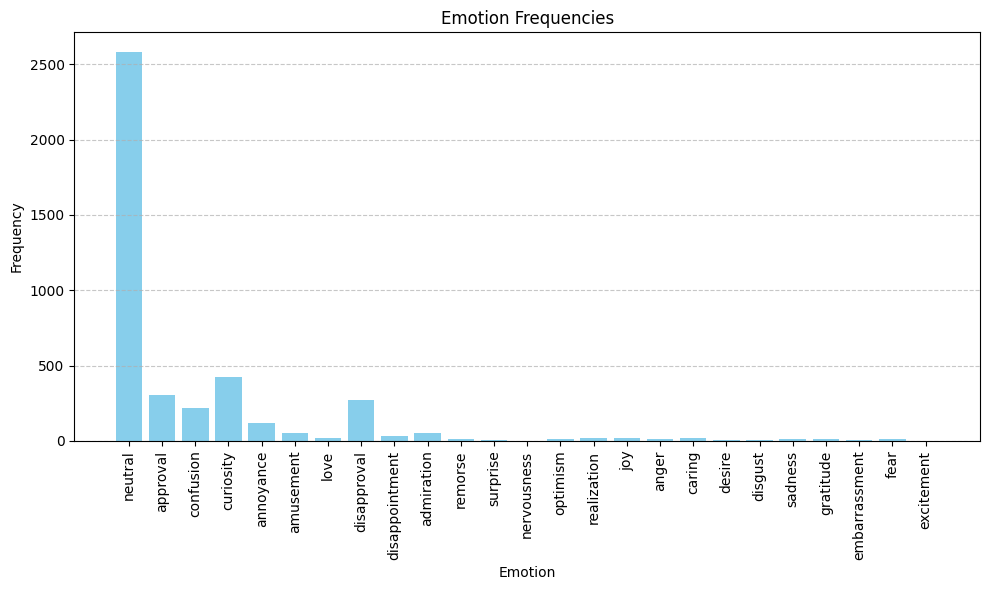

In [13]:
import matplotlib.pyplot as plt

# Extract emotion labels and corresponding frequencies from our final list
emotions = list(emotion_frequency_gpt.keys())
frequencies = list(emotion_frequency_gpt.values())

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotions, frequencies, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Emotion Frequencies')
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adjust layout to prevent label clips
plt.tight_layout()
plt.show()

# Emotions Analysis:

**Neutral Emotion Possibly Overrepresented**
Because understanding the complexity of these responses can be difficult, this is likely the reason that the 'neutral' emotion has such high frequency, and is possibly overrepresented given the actual range of emotions on r/CMV.

**Approval / Disapproval Emotions Common**
Due to the nature of binary discourse on r/CMV, people are generally either for or against a controversial discussion topic, and sometimes will even explicitly state 'I agree' or 'I disagree' in their comment.

**Logical Reasoning and Realization** On r/CMV, it is common to explain and think through the logic of an argument or perspective on a topic. This likely leads to the 'realization' emotion being significantly higher than the other emotions not mentioned above (ie compared to joy, surprise, relief, etc.).

# Visualization of GPT Emotions

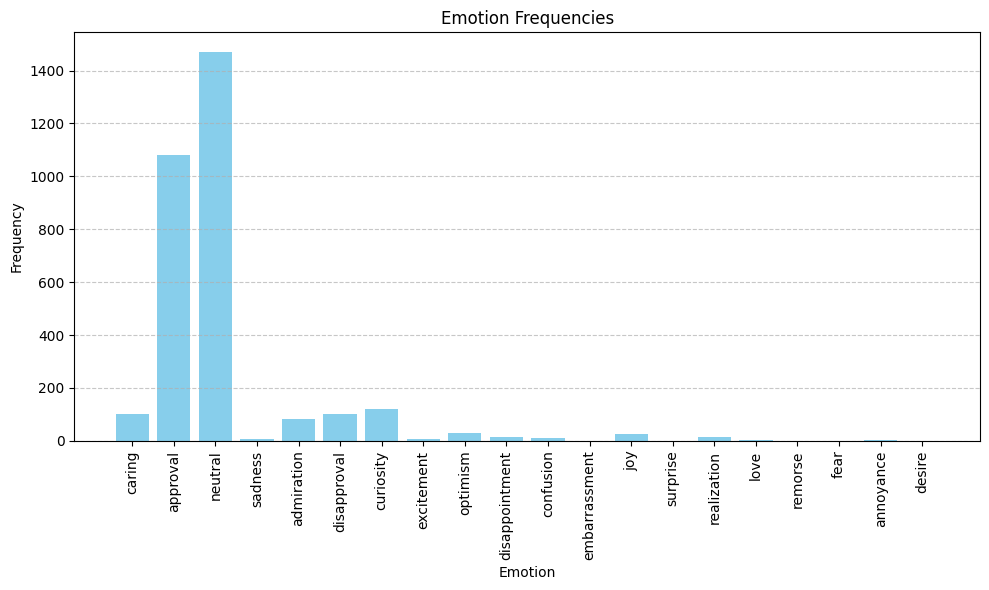

In [18]:
import matplotlib.pyplot as plt

# Extract emotion labels and corresponding frequencies from our final list
emotions = list(emotion_frequency_gpt.keys())
frequencies = list(emotion_frequency_gpt.values())

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotions, frequencies, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Emotion Frequencies')
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adjust layout to prevent label clips
plt.tight_layout()
plt.show()

# Visualization of Llama Emotions

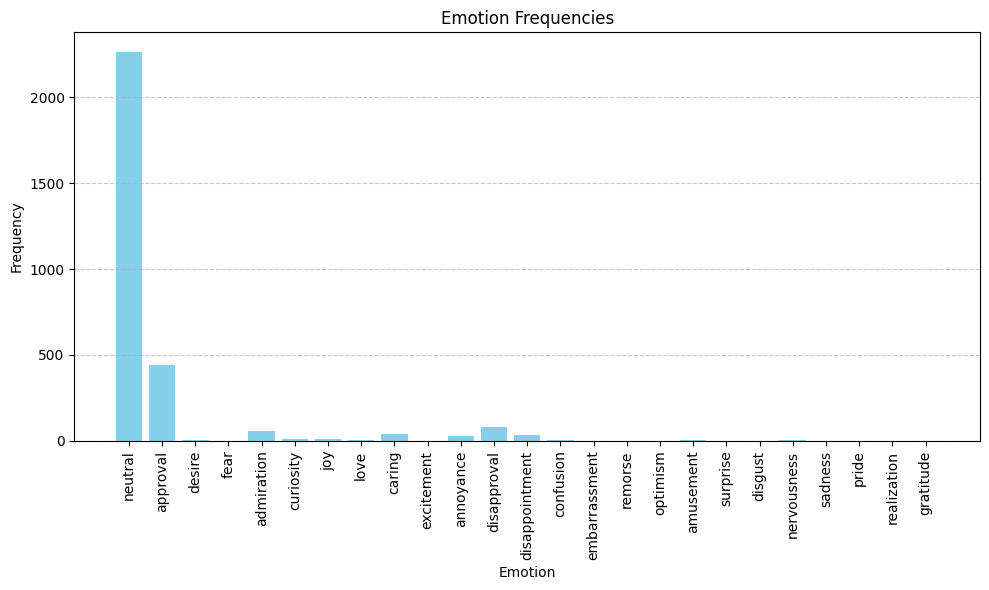

In [19]:
import matplotlib.pyplot as plt

# Extract emotion labels and corresponding frequencies from our final list
emotions = list(emotion_frequency_ll.keys())
frequencies = list(emotion_frequency_ll.values())

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotions, frequencies, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Emotion Frequencies')
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adjust layout to prevent label clips
plt.tight_layout()
plt.show()

# Visualization of Zephyr Emotions

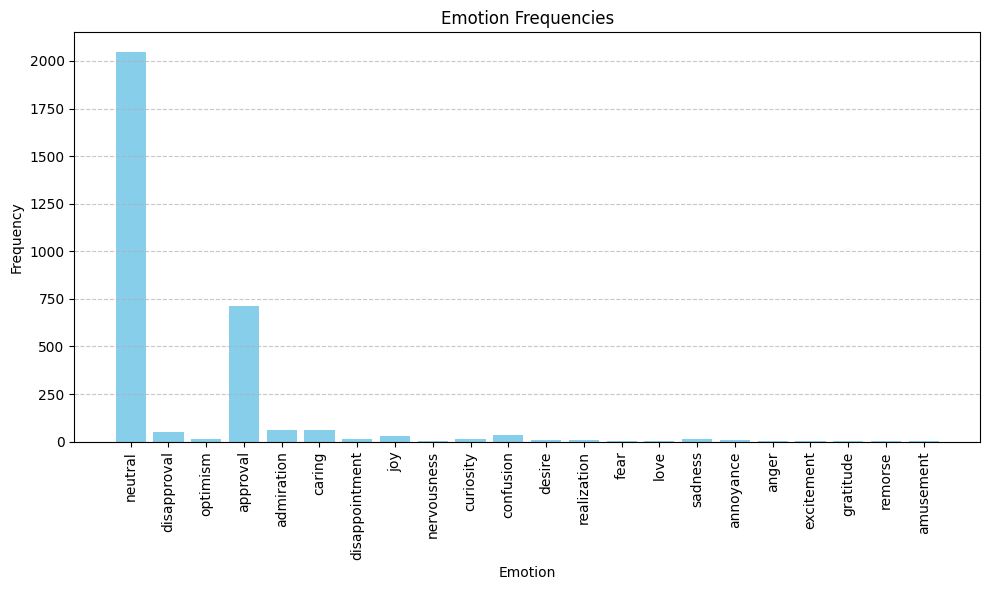

In [20]:
import matplotlib.pyplot as plt

# Extract emotion labels and corresponding frequencies from our final list
emotions = list(emotion_frequency_ze.keys())
frequencies = list(emotion_frequency_ze.values())

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotions, frequencies, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Emotion Frequencies')
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adjust layout to prevent label clips
plt.tight_layout()
plt.show()

# Aggregating Emotions based on Post Sentiment

Post Sentiment is one of the following options {Positive/Neutral/Negative}

In [22]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import chisquare

# Initialize the text classification pipeline for emotion analysis (Go emotions from Hugging Face)
# (see link above)
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5)

cmv_df = pd.read_csv('cmv_clean.csv')

# Define the mapping of emotions to sentiment categories
# From Go Emotions dataset (see link above)
emotion_sentiment_mapping = {
    'joy': 'positive',
    'optimism': 'positive',
    'amusement': 'positive',
    'love': 'positive',
    'excitement': 'positive',
    'admiration': 'positive',
    'relief': 'positive',
    'gratitude': 'positive',
    'pride': 'positive',
    'caring': 'positive',
    'approval': 'positive',
    'neutral': 'neutral',
    'surprise': 'neutral',
    'realization': 'neutral',
    'confusion': 'neutral',
    'curiosity': 'neutral',
    'disapproval': 'negative',
    'desire': 'negative',
    'remorse': 'negative',
    'disappointment': 'negative',
    'annoyance': 'negative',
    'nervousness': 'negative',
    'anger': 'negative',
    'fear': 'negative',
    'embarassment': 'negative',
    'sadness': 'negative',
    'grief': 'negative',
    'disgust': 'negative',
}

# Initialize count var for batch logging progress
count = 0

# Create a dictionary to store sentiment frequencies
sentiment_frequency = {'positive': 0, 'negative': 0, 'neutral': 0}

# Create a dictionary to store emotion frequencies for each sentiment category
emotion_frequency = {'positive': {}, 'negative': {}, 'neutral': {}}

def is_statistically_significant(sentiment_counts, sentiment_frequency):
    # Calculate the sum of observed frequencies (ie how many times did the emotion show up across all types of posts)
    observed_sum = sentiment_counts.sum()

    # Calculate the total number of posts
    total_posts = sum(sentiment_frequency.values())

    # Calculate expected proportions based on post distribution
    if total_posts > 0:
        expected_proportions = np.array([sentiment_frequency[key] / total_posts for key in sentiment_frequency.keys()])
        expected_counts = expected_proportions * observed_sum

    # Perform chi-squared test
    chi2_stat, p_val = chisquare(sentiment_counts, f_exp=expected_counts)

    # Determine if the test is statistically significant based on the p-value
    if p_val < 0.05:  # You can adjust the significance level (alpha) as needed
        print(f"Expected counts would have been: {expected_counts}")
        sig_expected_counts.append(expected_counts)
        print(f"Actual counts were: {sentiment_counts}")
        sig_actual_counts.append(sentiment_counts)
        return True, chi2_stat, p_val
    else:
        return False, chi2_stat, p_val

# Iterate over each row in the DataFrame
for index, row in cmv_df.iterrows():
    # Log Progress every 200 batches
    if count % 100 == 0:
      print(f"Number of posts analyzed: {count}")
      print(" Post Sentiment Distribution")
      print(sentiment_frequency)
      print("")

      print(" Comment Emotion Distribution for Posts")
      print(emotion_frequency)
      print("")

    # Process the post body for sentiment analysis
    post_body = str(row['Body'])

    # Truncate post_body if it exceeds 512 characters
    post_body = post_body[:512]

    if post_body:
        # Analyze emotions of the post body
        emotions = classifier(post_body)

        # Make sure we have emotions for the post
        if emotions and len(emotions) > 0:
            # Grab the top emotion for the post body
            top_emotion_post = emotions[0][0]['label']
            if top_emotion_post in emotion_sentiment_mapping:
                # Convert that top emotion into a sentiment (positive/neutral/negative)
                # for later analysis
                post_sentiment = emotion_sentiment_mapping[top_emotion_post]

                # Update sentiment frequency of posts
                sentiment_frequency[post_sentiment] += 1

        # Create our batch comments
        batch_comments = []
        for i in range(1, 6):
            comment_key = f'Comment {i}'
            # Truncate comments to first 512 characters
            row[comment_key] = str(row[comment_key])[:512]
            if isinstance(row[comment_key], str):
                batch_comments.append(row[comment_key])

        # Process the comments for emotion analysis (using top 5 comments)
        if batch_comments:
            for comment in batch_comments:
                # Grab the emotion with the highest probability rating
                top_emotion_comment = classifier(comment)[0][0]['label']
                if top_emotion_comment not in emotion_frequency[post_sentiment]:
                    # If the emotion does not exist, set freq to be 1 for the emotion
                    emotion_frequency[post_sentiment][top_emotion_comment] = 1
                else:
                    # Otherwise increment the current count for the emotion
                    emotion_frequency[post_sentiment][top_emotion_comment] += 1

        # increment our overall count that does batch logging
        count += 1

# Define the sentiment categories in the desired order
sentiment_categories = ['positive', 'negative', 'neutral']

# Define the complete list of emotions from the mapping
all_emotions = list(emotion_sentiment_mapping.keys())

# Initialize the contingency table with zeros
contingency_table = np.zeros((len(sentiment_categories), len(all_emotions)), dtype=int)

# Populate the contingency table with emotion frequencies
for i, sentiment in enumerate(sentiment_categories):
    for j, emotion in enumerate(all_emotions):
        if emotion in emotion_frequency[sentiment]:
            contingency_table[i, j] = emotion_frequency[sentiment][emotion]

# Emotion of interest (column index)
emotion_index = 0
significance_results = []
sig_expected_counts = []
sig_actual_counts = []
p_value_results = []

# Extract all sentiment values for the specified emotion (column)
for emotion in emotion_sentiment_mapping:
  # print(emotion_index)
  # print(emotion)
  sentiment_counts = contingency_table[:, emotion_index]
  # print(sentiment_counts)

  if np.all(sentiment_counts >= 1):
      is_significant, chi2_stat, p_val = is_statistically_significant(sentiment_counts, sentiment_frequency)

      print(f"Is the difference statistically significant? for emotion : {emotion}")
      if is_significant:
        print("Yes, it was significant")
        significance_results.append(emotion)
        p_value_results.append(p_val)
      else:
        print("No, it was not significant")
  else:
      print(f"Not enough information to perform the chi-squared test for emotion: {emotion}")

  emotion_index += 1

print("Final Post Sentiment Distribution")
print(sentiment_frequency)
print("")

print("Final Comment Emotion Distribution for Posts")
print(emotion_frequency)
print("")

# Final Results to prevent 1 hour + compute time
# Final Post Sentiment Distribution
# {'positive': 124, 'negative': 140, 'neutral': 580}

# Final Comment Emotion Distribution for Posts
# {'positive': {'neutral': 336, 'curiosity': 65, 'disapproval': 43, 'confusion': 26, 'love': 6, 'remorse': 4, 'approval': 61, 'annoyance': 20, 'amusement': 6, 'gratitude': 4, 'realization': 3, 'anger': 7, 'admiration': 22, 'caring': 1, 'desire': 1, 'fear': 1, 'joy': 5, 'disappointment': 6, 'sadness': 2, 'optimism': 1}, 'negative': {'neutral': 409, 'approval': 51, 'confusion': 35, 'disappointment': 11, 'amusement': 10, 'curiosity': 77, 'disapproval': 43, 'remorse': 1, 'joy': 2, 'anger': 1, 'desire': 5, 'caring': 10, 'sadness': 5, 'annoyance': 22, 'optimism': 2, 'realization': 3, 'admiration': 5, 'gratitude': 3, 'fear': 1, 'love': 2, 'nervousness': 1, 'disgust': 1}, 'neutral': {'neutral': 1839, 'approval': 193, 'confusion': 157, 'curiosity': 285, 'annoyance': 74, 'amusement': 35, 'love': 11, 'disapproval': 182, 'admiration': 23, 'surprise': 7, 'nervousness': 1, 'optimism': 9, 'realization': 11, 'disappointment': 16, 'caring': 9, 'disgust': 6, 'anger': 3, 'remorse': 6, 'gratitude': 5, 'joy': 10, 'sadness': 4, 'embarrassment': 3, 'fear': 8, 'desire': 2, 'excitement': 1}}


# Is the difference statistically significant? for emotion : joy
# No, it was not significant
# Is the difference statistically significant? for emotion : optimism
# No, it was not significant
# Is the difference statistically significant? for emotion : amusement
# No, it was not significant
# Is the difference statistically significant? for emotion : love
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: excitement
# Expected counts would have been: [ 7.34597156  8.29383886 34.36018957]
# Actual counts were: [22  5 23]
# Is the difference statistically significant? for emotion : admiration
# Yes, it was significant
# Not enough information to perform the chi-squared test for emotion: relief
# Is the difference statistically significant? for emotion : gratitude
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: pride
# Expected counts would have been: [ 2.93838863  3.31753555 13.74407583]
# Actual counts were: [ 1 10  9]
# Is the difference statistically significant? for emotion : caring
# Yes, it was significant
# Expected counts would have been: [ 44.81042654  50.59241706 209.5971564 ]
# Actual counts were: [ 61  51 193]
# Is the difference statistically significant? for emotion : approval
# Yes, it was significant
# Expected counts would have been: [ 379.63981043  428.62559242 1775.73459716]
# Actual counts were: [ 336  409 1839]
# Is the difference statistically significant? for emotion : neutral
# Yes, it was significant
# Not enough information to perform the chi-squared test for emotion: surprise
# Is the difference statistically significant? for emotion : realization
# No, it was not significant
# Is the difference statistically significant? for emotion : confusion
# No, it was not significant
# Is the difference statistically significant? for emotion : curiosity
# No, it was not significant
# Is the difference statistically significant? for emotion : disapproval
# No, it was not significant
# Expected counts would have been: [1.17535545 1.32701422 5.49763033]
# Actual counts were: [1 5 2]
# Is the difference statistically significant? for emotion : desire
# Yes, it was significant
# Is the difference statistically significant? for emotion : remorse
# No, it was not significant
# Expected counts would have been: [ 4.84834123  5.47393365 22.67772512]
# Actual counts were: [ 6 11 16]
# Is the difference statistically significant? for emotion : disappointment
# Yes, it was significant
# Is the difference statistically significant? for emotion : annoyance
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: nervousness
# Expected counts would have been: [1.61611374 1.82464455 7.55924171]
# Actual counts were: [7 1 3]
# Is the difference statistically significant? for emotion : anger
# Yes, it was significant
# Is the difference statistically significant? for emotion : fear
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: embarassment
# Expected counts would have been: [1.61611374 1.82464455 7.55924171]
# Actual counts were: [2 5 4]
# Is the difference statistically significant? for emotion : sadness
# Yes, it was significant
# Not enough information to perform the chi-squared test for emotion: grief
# Not enough information to perform the chi-squared test for emotion: disgust

Number of posts analyzed: 0
 Post Sentiment Distribution
{'positive': 0, 'negative': 0, 'neutral': 0}

 Comment Emotion Distribution for Posts
{'positive': {}, 'negative': {}, 'neutral': {}}

Number of posts analyzed: 100
 Post Sentiment Distribution
{'positive': 17, 'negative': 14, 'neutral': 69}

 Comment Emotion Distribution for Posts
{'positive': {'neutral': 48, 'curiosity': 12, 'disapproval': 8, 'confusion': 6, 'love': 1, 'remorse': 1, 'approval': 5, 'annoyance': 1, 'amusement': 2, 'gratitude': 1}, 'negative': {'neutral': 44, 'approval': 4, 'confusion': 2, 'disappointment': 1, 'amusement': 1, 'curiosity': 7, 'disapproval': 5, 'remorse': 1, 'joy': 1, 'anger': 1, 'desire': 1, 'caring': 1, 'sadness': 1}, 'neutral': {'neutral': 219, 'approval': 27, 'confusion': 22, 'curiosity': 28, 'annoyance': 5, 'amusement': 3, 'love': 3, 'disapproval': 21, 'admiration': 3, 'surprise': 2, 'nervousness': 1, 'optimism': 1, 'realization': 2, 'disappointment': 3, 'caring': 1, 'disgust': 2, 'anger': 1, '

In [ ]:
# Plotting results
import matplotlib.pyplot as plt
# Plotting results for significantly significant emotions
plt.figure(figsize=(12, 8))
plt.bar(significance_results, p_value_results, color='green')
plt.title('Statistically Significant Emotions with P-values')
plt.xlabel('Emotion')
plt.ylabel('P-value')
plt.yscale('log')  # Use logarithmic scale for better visualization of p-values
plt.xticks(rotation=45, ha='right')  # Rotate x-tick labels for better readability
plt.axhline(0.05, color='red', linestyle='--', label='Significance Threshold (p = 0.05)')  # Add significance threshold line
plt.legend()
plt.show()

In [ ]:


# Calculate the difference between observed and expected counts
difference = np.array(sig_actual_counts) - np.array(sig_expected_counts)

# Flatten the difference array to a 1D array
difference_flat = difference.flatten()
print(difference_flat)

# Define sentiments and corresponding indices for bar plotting
sentiments = ['Positive', 'Negative', 'Neutral']
indices = np.arange(len(significance_results) * len(sentiments))  # Indices for x-axis positions

# Define colors based on the sign of the difference
bar_colors = np.where(difference_flat > 0, 'green', 'red')

# Plotting the bar graph
plt.figure(figsize=(12, 8))
bars = plt.bar(indices, difference_flat, color=bar_colors)

# Add labels, title, and legend
plt.xlabel('Emotion')
plt.ylabel('Difference (Observed - Expected)')
plt.title('Difference in Counts for Significant Emotions')
# plt.xticks(indices, np.tile(significance_results, len(sentiments)), rotation=45, ha='right')  # Set x-axis labels
emotions_repeated = np.repeat(significance_results, num_sentiments)
plt.xticks(indices, emotions_repeated, rotation=75, ha='right')  # Set x-axis labels
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add horizontal line at y=0

# Add annotations for significant differences
for i, bar, diff in zip(indices, bars, difference_flat):
    if np.abs(diff) > 0.05 * np.mean(sig_expected_counts):
        plt.text(i, bar.get_height() + 10, 'Significant', ha='center', va='bottom', color='blue', weight='bold', rotation=45,)

plt.tight_layout()
plt.show()


# Overall Post Sentiment Distribution

Positive / Neutral / Negative

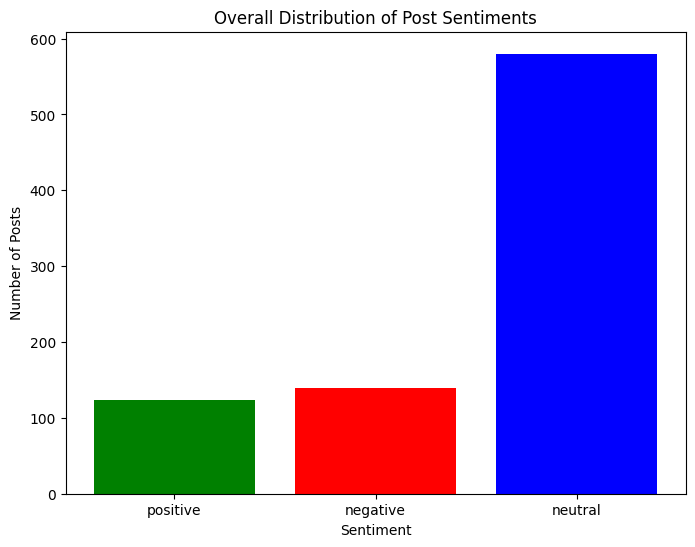

In [23]:
# Data for the overall distribution of post sentiments
sentiments = list(sentiment_frequency.keys())
counts = list(sentiment_frequency.values())

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiments, counts, color=['green', 'red', 'blue'])
plt.title('Overall Distribution of Post Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.show()


# Respective Emotion Distribution for Post Sentiment

28 Unique Emotions (Go Emotions) - See Motivation Above

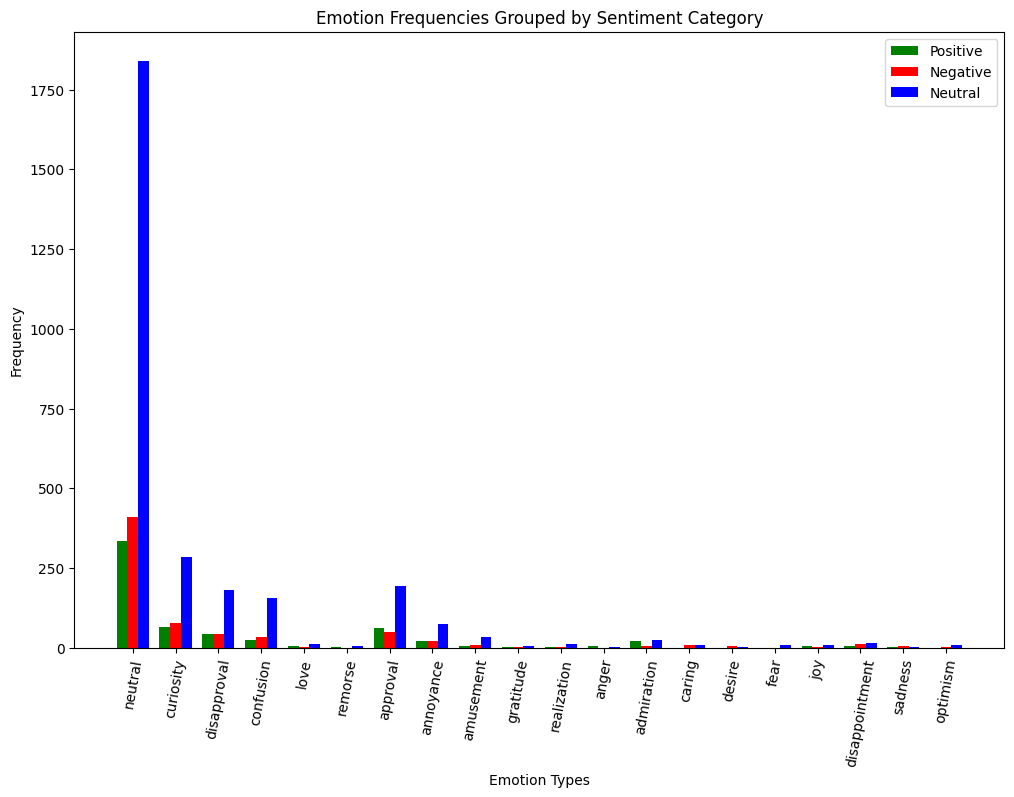

In [24]:
# Data for emotion frequencies across different sentiment categories
sentiments = list(emotion_frequency.keys())
emotion_types = list(emotion_frequency['positive'].keys())
num_emotions = len(emotion_types)

# Prepare data for the grouped bar chart
positive_emotions = [emotion_frequency['positive'].get(emotion, 0) for emotion in emotion_types]
negative_emotions = [emotion_frequency['negative'].get(emotion, 0) for emotion in emotion_types]
neutral_emotions = [emotion_frequency['neutral'].get(emotion, 0) for emotion in emotion_types]

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Set width of bars
bar_width = 0.25
index = np.arange(num_emotions)

# Plotting the grouped bar chart
bar1 = ax.bar(index - bar_width, positive_emotions, bar_width, label='Positive', color='green')
bar2 = ax.bar(index, negative_emotions, bar_width, label='Negative', color='red')
bar3 = ax.bar(index + bar_width, neutral_emotions, bar_width, label='Neutral', color='blue')

# Add labels, title, and legend
ax.set_xlabel('Emotion Types')
ax.set_ylabel('Frequency')
ax.set_title('Emotion Frequencies Grouped by Sentiment Category')
ax.set_xticks(index)
ax.set_xticklabels(emotion_types, rotation=80)

# Add a legend for sentiment categories
ax.legend(['Positive', 'Negative', 'Neutral'])

# Show the plot
plt.show()


**Positive Reddit Posts Emotion Distribution**

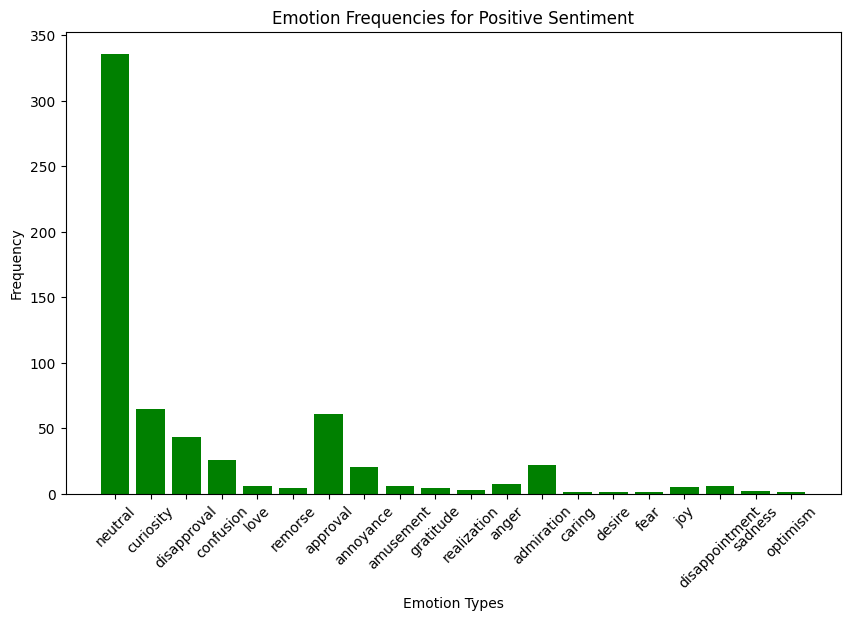

In [25]:
import matplotlib.pyplot as plt

# Data for positive sentiment emotions
positive_emotions = emotion_frequency['positive']

# Plotting the bar chart for positive sentiment emotions
plt.figure(figsize=(10, 6))
plt.bar(positive_emotions.keys(), positive_emotions.values(), color='green')
plt.title('Emotion Frequencies for Positive Sentiment')
plt.xlabel('Emotion Types')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


**Neutral Reddit Posts Emotion Distribution**

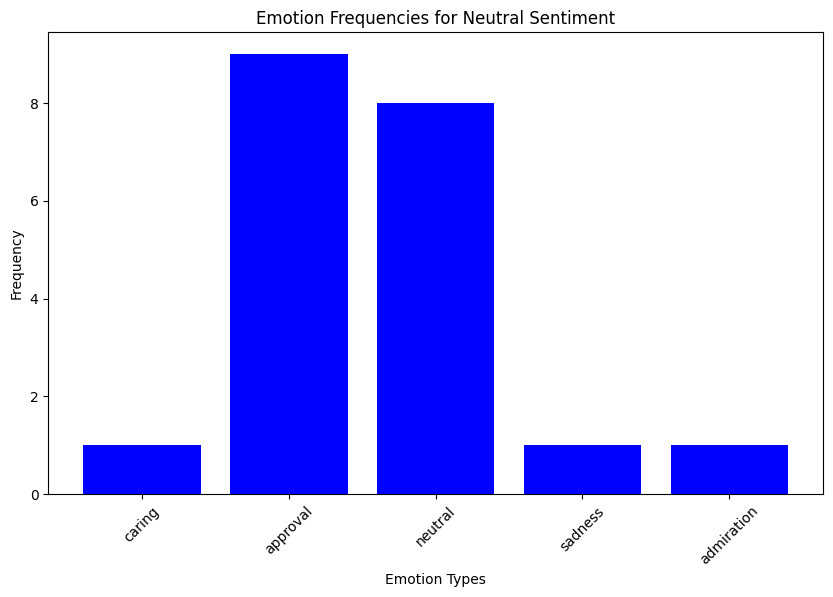

In [40]:
import matplotlib.pyplot as plt

# Data for neutral sentiment emotions
neutral_emotions = emotion_frequency['neutral']

# Plotting the bar chart for neutral sentiment emotions
plt.figure(figsize=(10, 6))
plt.bar(neutral_emotions.keys(), neutral_emotions.values(), color='blue')
plt.title('Emotion Frequencies for Neutral Sentiment')
plt.xlabel('Emotion Types')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


**Negative Reddit Posts Emotion Distribution**

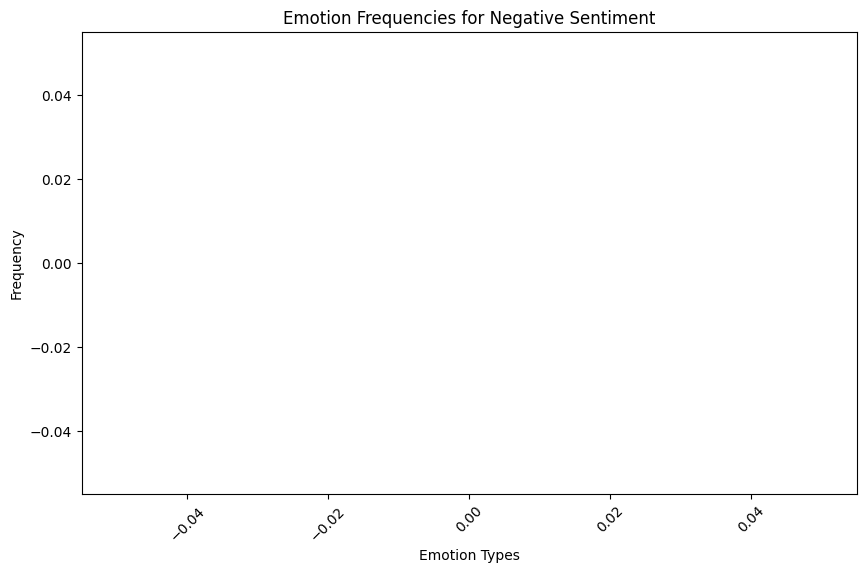

In [41]:
import matplotlib.pyplot as plt

# Data for negative sentiment emotions
negative_emotions = emotion_frequency['negative']

# Plotting the bar chart for negative sentiment emotions
plt.figure(figsize=(10, 6))
plt.bar(negative_emotions.keys(), negative_emotions.values(), color='red')
plt.title('Emotion Frequencies for Negative Sentiment')
plt.xlabel('Emotion Types')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# LLM Emotion Distribution as a Function of Post Sentiment

GPT

In [42]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import chisquare

# Initialize the text classification pipeline for emotion analysis (Go emotions from Hugging Face)
# (see link above)
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5)

cmv_df = pd.read_csv('GPT*.csv')

# Define the mapping of emotions to sentiment categories
# From Go Emotions dataset (see link above)
emotion_sentiment_mapping = {
    'joy': 'positive',
    'optimism': 'positive',
    'amusement': 'positive',
    'love': 'positive',
    'excitement': 'positive',
    'admiration': 'positive',
    'relief': 'positive',
    'gratitude': 'positive',
    'pride': 'positive',
    'caring': 'positive',
    'approval': 'positive',
    'neutral': 'neutral',
    'surprise': 'neutral',
    'realization': 'neutral',
    'confusion': 'neutral',
    'curiosity': 'neutral',
    'disapproval': 'negative',
    'desire': 'negative',
    'remorse': 'negative',
    'disappointment': 'negative',
    'annoyance': 'negative',
    'nervousness': 'negative',
    'anger': 'negative',
    'fear': 'negative',
    'embarassment': 'negative',
    'sadness': 'negative',
    'grief': 'negative',
    'disgust': 'negative',
}

# Initialize count var for batch logging progress
count = 0

# Create a dictionary to store sentiment frequencies
sentiment_frequency = {'positive': 0, 'negative': 0, 'neutral': 0}

# Create a dictionary to store emotion frequencies for each sentiment category
emotion_frequency = {'positive': {}, 'negative': {}, 'neutral': {}}

def is_statistically_significant(sentiment_counts, sentiment_frequency):
    # Calculate the sum of observed frequencies (ie how many times did the emotion show up across all types of posts)
    observed_sum = sentiment_counts.sum()

    # Calculate the total number of posts
    total_posts = sum(sentiment_frequency.values())

    # Calculate expected proportions based on post distribution
    if total_posts > 0:
        expected_proportions = np.array([sentiment_frequency[key] / total_posts for key in sentiment_frequency.keys()])
        expected_counts = expected_proportions * observed_sum

        # print(f"Expected counts would have been: {expected_counts}")
        # print(f"Actual counts were: {sentiment_counts}")

    # Perform chi-squared test
    chi2_stat, p_val = chisquare(sentiment_counts, f_exp=expected_counts)

    # Determine if the test is statistically significant based on the p-value
    if p_val < 0.05:  # You can adjust the significance level (alpha) as needed
        print(f"Expected counts would have been: {expected_counts}")
        sig_expected_counts.append(expected_counts)
        print(f"Actual counts were: {sentiment_counts}")
        sig_actual_counts.append(sentiment_counts)
        return True, chi2_stat, p_val
    else:
        return False, chi2_stat, p_val

# Iterate over each row in the DataFrame
for index, row in cmv_df.iterrows():
    # Log Progress every 200 batches
    # print(count)
    # if (count / 5) > 199:
    #     break;
    if (count / 5) % 25 == 0:
      print(f"Number of Posts analyzed: {int(count / 5)}")
      print(" Post Sentiment Distribution")
      print(sentiment_frequency)
      print("")

    #   print(" Comment Emotion Distribution for Posts")
    #   print(emotion_frequency)
    #   print("")

    # Process the post body for sentiment analysis
    post_body = str(row['Query'])

    # Truncate post_body if it exceeds 512 characters
    post_body = post_body[:512]

    if post_body:
        # print(post_body)
        # print("")
        # Analyze emotions of the post body
        emotions = classifier(post_body)

        # Make sure we have emotions for the post
        if emotions and len(emotions) > 0 and count % 5 == 0:
            # print(post_body)
            # Grab the top emotion for the post body
            top_emotion_post = emotions[0][0]['label']
            # print("")
            # print(top_emotion_post)
            # print("")

            # print(top_emotion_post)
            # print("")
            # print("")
            if top_emotion_post in emotion_sentiment_mapping:
                # Convert that top emotion into a sentiment (positive/neutral/negative)
                # for later analysis
                post_sentiment = emotion_sentiment_mapping[top_emotion_post]

                # Update sentiment frequency of posts
                sentiment_frequency[post_sentiment] += 1
            # print(sentiment_frequency)

        response = row[f'Response']
        if isinstance(response, str):
            response = response[:512]
            # print(response)

            output = classifier(response)
            # print(output)
            # Grab emotion labels for each output
            top_emotion_comment = output[0][0]['label']
            # Update emotion frequency dictionary
            if top_emotion_comment not in emotion_frequency[post_sentiment]:
                # If the emotion does not exist, set freq to be 1 for the emotion
                emotion_frequency[post_sentiment][top_emotion_comment] = 1
            else:
                # Otherwise increment the current count for the emotion
                emotion_frequency[post_sentiment][top_emotion_comment] += 1

        # increment our overall count that does batch logging
        count += 1

# Define the sentiment categories in the desired order
sentiment_categories = ['positive', 'negative', 'neutral']

# Define the complete list of emotions from the mapping
all_emotions = list(emotion_sentiment_mapping.keys())

# Initialize the contingency table with zeros
contingency_table = np.zeros((len(sentiment_categories), len(all_emotions)), dtype=int)

# Populate the contingency table with emotion frequencies
for i, sentiment in enumerate(sentiment_categories):
    for j, emotion in enumerate(all_emotions):
        if emotion in emotion_frequency[sentiment]:
            contingency_table[i, j] = emotion_frequency[sentiment][emotion]

# Emotion of interest (column index)
emotion_index = 0
significance_results = []
sig_expected_counts = []
sig_actual_counts = []
p_value_results = []

# Extract all sentiment values for the specified emotion (column)
for emotion in emotion_sentiment_mapping:
  # print(emotion_index)
  # print(emotion)
  sentiment_counts = contingency_table[:, emotion_index]
  # print(sentiment_counts)

  if np.all(sentiment_counts >= 1):
      is_significant, chi2_stat, p_val = is_statistically_significant(sentiment_counts, sentiment_frequency)

      print(f"Is the difference statistically significant? for emotion : {emotion}")
      if is_significant:
        print("Yes, it was significant")
        significance_results.append(emotion)
        p_value_results.append(p_val)
      else:
        print("No, it was not significant")
  else:
      print(f"Not enough information to perform the chi-squared test for emotion: {emotion}")

  emotion_index += 1

print("Final Post Sentiment Distribution")
print(sentiment_frequency)
print("")

print("Final Comment Emotion Distribution for Posts")
print(emotion_frequency)
print("")

# Number of Posts analyzed: 600
#  Post Sentiment Distribution
# {'positive': 89, 'negative': 91, 'neutral': 420}

# Is the difference statistically significant? for emotion : joy
# No, it was not significant
# Is the difference statistically significant? for emotion : optimism
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: amusement
# Not enough information to perform the chi-squared test for emotion: love
# Not enough information to perform the chi-squared test for emotion: excitement
# Expected counts would have been: [12.14814815 12.41223833 57.43961353]
# Actual counts were: [33  8 41]
# Is the difference statistically significant? for emotion : admiration
# Yes, it was significant
# Not enough information to perform the chi-squared test for emotion: relief
# Not enough information to perform the chi-squared test for emotion: gratitude
# Not enough information to perform the chi-squared test for emotion: pride
# Is the difference statistically significant? for emotion : caring
# No, it was not significant
# Is the difference statistically significant? for emotion : approval
# No, it was not significant
# Expected counts would have been: [ 217.92592593  222.66344605 1030.41062802]
# Actual counts were: [ 161  230 1080]
# Is the difference statistically significant? for emotion : neutral
# Yes, it was significant
# Not enough information to perform the chi-squared test for emotion: surprise
# Is the difference statistically significant? for emotion : realization
# No, it was not significant
# Is the difference statistically significant? for emotion : confusion
# No, it was not significant
# Expected counts would have been: [18.07407407 18.46698873 85.4589372 ]
# Actual counts were: [29 31 62]
# Is the difference statistically significant? for emotion : curiosity
# Yes, it was significant
# Is the difference statistically significant? for emotion : disapproval
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: desire
# Not enough information to perform the chi-squared test for emotion: remorse
# Is the difference statistically significant? for emotion : disappointment
# No, it was not significant
# Is the difference statistically significant? for emotion : annoyance
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: nervousness
# Not enough information to perform the chi-squared test for emotion: anger
# Not enough information to perform the chi-squared test for emotion: fear
# Not enough information to perform the chi-squared test for emotion: embarassment
# Is the difference statistically significant? for emotion : sadness
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: grief
# Not enough information to perform the chi-squared test for emotion: disgust
# Final Post Sentiment Distribution
# {'positive': 92, 'negative': 94, 'neutral': 435}

# Final Comment Emotion Distribution for Posts
# {'positive': {'approval': 184, 'neutral': 161, 'excitement': 2, 'admiration': 33, 'curiosity': 29, 'disappointment': 3, 'disapproval': 12, 'optimism': 5, 'caring': 17, 'confusion': 1, 'joy': 4, 'realization': 1, 'annoyance': 1, 'sadness': 1}, 'negative': {'neutral': 230, 'admiration': 8, 'approval': 145, 'curiosity': 31, 'caring': 23, 'disappointment': 5, 'confusion': 1, 'embarrassment': 1, 'disapproval': 14, 'joy': 2, 'sadness': 2, 'optimism': 4, 'annoyance': 1, 'realization': 1}, 'neutral': {'caring': 60, 'approval': 752, 'neutral': 1080, 'sadness': 4, 'admiration': 41, 'disapproval': 76, 'curiosity': 62, 'optimism': 20, 'disappointment': 7, 'confusion': 9, 'joy': 19, 'surprise': 1, 'realization': 13, 'love': 3, 'remorse': 1, 'fear': 1, 'annoyance': 3, 'excitement': 5, 'desire': 1}}

Number of Posts analyzed: 0
 Post Sentiment Distribution
{'positive': 0, 'negative': 0, 'neutral': 0}

Number of Posts analyzed: 25
 Post Sentiment Distribution
{'positive': 2, 'negative': 6, 'neutral': 17}

Number of Posts analyzed: 50
 Post Sentiment Distribution
{'positive': 7, 'negative': 7, 'neutral': 36}

Number of Posts analyzed: 75
 Post Sentiment Distribution
{'positive': 14, 'negative': 12, 'neutral': 49}

Number of Posts analyzed: 100
 Post Sentiment Distribution
{'positive': 18, 'negative': 12, 'neutral': 70}

Number of Posts analyzed: 125
 Post Sentiment Distribution
{'positive': 22, 'negative': 13, 'neutral': 90}

Number of Posts analyzed: 150
 Post Sentiment Distribution
{'positive': 28, 'negative': 16, 'neutral': 106}

Number of Posts analyzed: 175
 Post Sentiment Distribution
{'positive': 30, 'negative': 20, 'neutral': 125}

Number of Posts analyzed: 200
 Post Sentiment Distribution
{'positive': 35, 'negative': 24, 'neutral': 141}

Number of Posts analyzed: 225
 Post S

[ 20.85185185  -4.41223833 -16.43961353 -56.92592593   7.33655395
  49.58937198  10.92592593  12.53301127 -23.4589372 ]


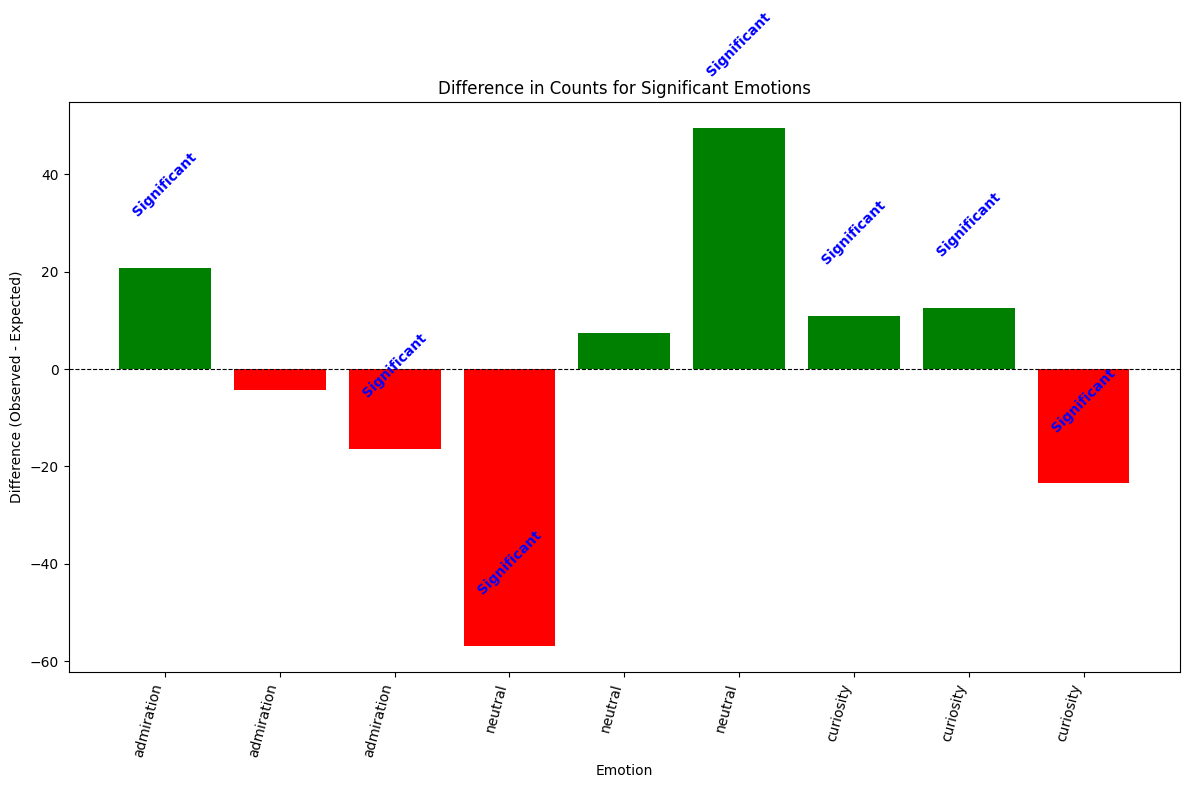

In [43]:
import matplotlib.pyplot as plt

# Calculate the difference between observed and expected counts
difference = np.array(sig_actual_counts) - np.array(sig_expected_counts)

# Flatten the difference array to a 1D array
difference_flat = difference.flatten()
print(difference_flat)

# Define sentiments and corresponding indices for bar plotting
sentiments = ['Positive', 'Negative', 'Neutral']
indices = np.arange(len(significance_results) * len(sentiments))  # Indices for x-axis positions

# Define colors based on the sign of the difference
bar_colors = np.where(difference_flat > 0, 'green', 'red')

# Plotting the bar graph
plt.figure(figsize=(12, 8))
bars = plt.bar(indices, difference_flat, color=bar_colors)

# Add labels, title, and legend
plt.xlabel('Emotion')
plt.ylabel('Difference (Observed - Expected)')
plt.title('Difference in Counts for Significant Emotions')
emotions_repeated = np.repeat(significance_results, 3)
# plt.xticks(indices, np.tile(significance_results, len(sentiments)), rotation=45, ha='right')  # Set x-axis labels
plt.xticks(indices, emotions_repeated, rotation=75, ha='right')  # Set x-axis labels
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add horizontal line at y=0

# Add annotations for significant differences
for i, bar, diff in zip(indices, bars, difference_flat):
    if np.abs(diff) > 0.05 * np.mean(sig_expected_counts):
        plt.text(i, bar.get_height() + 10, 'Significant', ha='center', va='bottom', color='blue', weight='bold', rotation=45,)

plt.tight_layout()
plt.show()


Llama

In [44]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import chisquare

# Initialize the text classification pipeline for emotion analysis (Go emotions from Hugging Face)
# (see link above)
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5)

cmv_df = pd.read_csv('LL*.csv')

# Define the mapping of emotions to sentiment categories
# From Go Emotions dataset (see link above)
emotion_sentiment_mapping = {
    'joy': 'positive',
    'optimism': 'positive',
    'amusement': 'positive',
    'love': 'positive',
    'excitement': 'positive',
    'admiration': 'positive',
    'relief': 'positive',
    'gratitude': 'positive',
    'pride': 'positive',
    'caring': 'positive',
    'approval': 'positive',
    'neutral': 'neutral',
    'surprise': 'neutral',
    'realization': 'neutral',
    'confusion': 'neutral',
    'curiosity': 'neutral',
    'disapproval': 'negative',
    'desire': 'negative',
    'remorse': 'negative',
    'disappointment': 'negative',
    'annoyance': 'negative',
    'nervousness': 'negative',
    'anger': 'negative',
    'fear': 'negative',
    'embarassment': 'negative',
    'sadness': 'negative',
    'grief': 'negative',
    'disgust': 'negative',
}

# Initialize count var for batch logging progress
count = 0

# Create a dictionary to store sentiment frequencies
sentiment_frequency = {'positive': 0, 'negative': 0, 'neutral': 0}

# Create a dictionary to store emotion frequencies for each sentiment category
emotion_frequency = {'positive': {}, 'negative': {}, 'neutral': {}}

def is_statistically_significant(sentiment_counts, sentiment_frequency):
    # Calculate the sum of observed frequencies (ie how many times did the emotion show up across all types of posts)
    observed_sum = sentiment_counts.sum()

    # Calculate the total number of posts
    total_posts = sum(sentiment_frequency.values())

    # Calculate expected proportions based on post distribution
    if total_posts > 0:
        expected_proportions = np.array([sentiment_frequency[key] / total_posts for key in sentiment_frequency.keys()])
        expected_counts = expected_proportions * observed_sum

    # Perform chi-squared test
    chi2_stat, p_val = chisquare(sentiment_counts, f_exp=expected_counts)

    # Determine if the test is statistically significant based on the p-value
    if p_val < 0.05:  # You can adjust the significance level (alpha) as needed
        print(f"Expected counts would have been: {expected_counts}")
        sig_expected_counts.append(expected_counts)
        print(f"Actual counts were: {sentiment_counts}")
        sig_actual_counts.append(sentiment_counts)
        return True, chi2_stat, p_val
    else:
        return False, chi2_stat, p_val

# Iterate over each row in the DataFrame
for index, row in cmv_df.iterrows():
    # Log Progress every 200 batches
    # if (count / 5) > 199:
    #     break;
    if (count / 5) % 25 == 0:
      print(f"Number of Posts analyzed: {int(count / 5)}")
      print(" Post Sentiment Distribution")
      print(sentiment_frequency)
      print("")
    # if (count / 5) % 5 == 0:
    #   print(f"Number of Posts analyzed: {int(count / 5)}")
    #   print(" Post Sentiment Distribution")
    #   print(sentiment_frequency)
    #   print("")

    #   print(" Comment Emotion Distribution for Posts")
    #   print(emotion_frequency)
    #   print("")

    # Process the post body for sentiment analysis
    post_body = str(row['Query'])

    # Truncate post_body if it exceeds 512 characters
    post_body = post_body[:512]

    if post_body:
        # print(post_body)
        # print("")
        # Analyze emotions of the post body
        emotions = classifier(post_body)

        # Make sure we have emotions for the post
        if emotions and len(emotions) > 0 and count % 5 == 0:
            # print(post_body)
            # Grab the top emotion for the post body
            top_emotion_post = emotions[0][0]['label']
            # print("")
            # print(top_emotion_post)
            # print("")

            # print(top_emotion_post)
            # print("")
            # print("")
            if top_emotion_post in emotion_sentiment_mapping:
                # Convert that top emotion into a sentiment (positive/neutral/negative)
                # for later analysis
                post_sentiment = emotion_sentiment_mapping[top_emotion_post]

                # Update sentiment frequency of posts
                sentiment_frequency[post_sentiment] += 1
            # print(sentiment_frequency)

        response = row[f'Response']
        if isinstance(response, str):
            response = response[:512]
            # print(response)

            output = classifier(response)
            # print(output)
            # Grab emotion labels for each output
            top_emotion_comment = output[0][0]['label']
            # Update emotion frequency dictionary
            if top_emotion_comment not in emotion_frequency[post_sentiment]:
                # If the emotion does not exist, set freq to be 1 for the emotion
                emotion_frequency[post_sentiment][top_emotion_comment] = 1
            else:
                # Otherwise increment the current count for the emotion
                emotion_frequency[post_sentiment][top_emotion_comment] += 1

        # increment our overall count that does batch logging
        count += 1

# Define the sentiment categories in the desired order
sentiment_categories = ['positive', 'negative', 'neutral']

# Define the complete list of emotions from the mapping
all_emotions = list(emotion_sentiment_mapping.keys())

# Initialize the contingency table with zeros
contingency_table = np.zeros((len(sentiment_categories), len(all_emotions)), dtype=int)

# Populate the contingency table with emotion frequencies
for i, sentiment in enumerate(sentiment_categories):
    for j, emotion in enumerate(all_emotions):
        if emotion in emotion_frequency[sentiment]:
            contingency_table[i, j] = emotion_frequency[sentiment][emotion]

# Emotion of interest (column index)
emotion_index = 0
significance_results = []
sig_expected_counts = []
sig_actual_counts = []
p_value_results = []

# Extract all sentiment values for the specified emotion (column)
for emotion in emotion_sentiment_mapping:
  # print(emotion_index)
  # print(emotion)
  sentiment_counts = contingency_table[:, emotion_index]
  # print(sentiment_counts)

  if np.all(sentiment_counts >= 1):
      is_significant, chi2_stat, p_val = is_statistically_significant(sentiment_counts, sentiment_frequency)

      print(f"Is the difference statistically significant? for emotion : {emotion}")
      if is_significant:
        print("Yes, it was significant")
        significance_results.append(emotion)
        p_value_results.append(p_val)
      else:
        print("No, it was not significant")
  else:
      print(f"Not enough information to perform the chi-squared test for emotion: {emotion}")

  emotion_index += 1

print("Final Post Sentiment Distribution")
print(sentiment_frequency)
print("")

print("Final Comment Emotion Distribution for Posts")
print(emotion_frequency)
print("")

# Expected counts would have been: [1.48148148 1.5136876  7.00483092]
# Actual counts were: [5 1 4]
# Is the difference statistically significant? for emotion : joy
# Yes, it was significant
# Not enough information to perform the chi-squared test for emotion: optimism
# Is the difference statistically significant? for emotion : amusement
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: love
# Not enough information to perform the chi-squared test for emotion: excitement
# Expected counts would have been: [ 8.74074074  8.93075684 41.32850242]
# Actual counts were: [26  4 29]
# Is the difference statistically significant? for emotion : admiration
# Yes, it was significant
# Not enough information to perform the chi-squared test for emotion: relief
# Not enough information to perform the chi-squared test for emotion: gratitude
# Not enough information to perform the chi-squared test for emotion: pride
# Is the difference statistically significant? for emotion : caring
# No, it was not significant
# Expected counts would have been: [ 65.18518519  66.60225443 308.21256039]
# Actual counts were: [101  54 285]
# Is the difference statistically significant? for emotion : approval
# Yes, it was significant
# Expected counts would have been: [ 335.7037037   343.00161031 1587.29468599]
# Actual counts were: [ 271  338 1657]
# Is the difference statistically significant? for emotion : neutral
# Yes, it was significant
# Not enough information to perform the chi-squared test for emotion: surprise
# Not enough information to perform the chi-squared test for emotion: realization
# Is the difference statistically significant? for emotion : confusion
# No, it was not significant
# Expected counts would have been: [1.92592593 1.96779388 9.10628019]
# Actual counts were: [8 2 3]
# Is the difference statistically significant? for emotion : curiosity
# Yes, it was significant
# Is the difference statistically significant? for emotion : disapproval
# No, it was not significant
# Is the difference statistically significant? for emotion : desire
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: remorse
# Is the difference statistically significant? for emotion : disappointment
# No, it was not significant
# Expected counts would have been: [ 4.44444444  4.5410628  21.01449275]
# Actual counts were: [ 2 22  6]
# Is the difference statistically significant? for emotion : annoyance
# Yes, it was significant
# Not enough information to perform the chi-squared test for emotion: nervousness
# Not enough information to perform the chi-squared test for emotion: anger
# Not enough information to perform the chi-squared test for emotion: fear
# Not enough information to perform the chi-squared test for emotion: embarassment
# Not enough information to perform the chi-squared test for emotion: sadness
# Not enough information to perform the chi-squared test for emotion: grief
# Not enough information to perform the chi-squared test for emotion: disgust
# Final Post Sentiment Distribution
# {'positive': 92, 'negative': 94, 'neutral': 435}

# Final Comment Emotion Distribution for Posts
# {'positive': {'love': 1, 'approval': 101, 'caring': 10, 'annoyance': 2, 'neutral': 271, 'disapproval': 11, 'joy': 5, 'confusion': 1, 'remorse': 1, 'curiosity': 8, 'disappointment': 3, 'admiration': 26, 'desire': 2, 'realization': 1, 'gratitude': 1, 'amusement': 1}, 'negative': {'neutral': 338, 'admiration': 4, 'curiosity': 2, 'desire': 1, 'caring': 8, 'approval': 54, 'annoyance': 22, 'embarrassment': 1, 'amusement': 1, 'disgust': 1, 'disapproval': 12, 'confusion': 3, 'disappointment': 3, 'joy': 1, 'nervousness': 1}, 'neutral': {'neutral': 1657, 'approval': 285, 'desire': 1, 'fear': 1, 'admiration': 29, 'joy': 4, 'excitement': 1, 'curiosity': 3, 'disapproval': 58, 'disappointment': 27, 'confusion': 3, 'caring': 22, 'love': 6, 'optimism': 1, 'annoyance': 6, 'remorse': 1, 'surprise': 1, 'nervousness': 2, 'sadness': 2, 'pride': 1, 'realization': 1, 'amusement': 1}}

Number of Posts analyzed: 0
 Post Sentiment Distribution
{'positive': 0, 'negative': 0, 'neutral': 0}

Number of Posts analyzed: 25
 Post Sentiment Distribution
{'positive': 2, 'negative': 6, 'neutral': 17}

Number of Posts analyzed: 50
 Post Sentiment Distribution
{'positive': 7, 'negative': 7, 'neutral': 36}

Number of Posts analyzed: 75
 Post Sentiment Distribution
{'positive': 14, 'negative': 12, 'neutral': 49}

Number of Posts analyzed: 100
 Post Sentiment Distribution
{'positive': 18, 'negative': 12, 'neutral': 70}

Number of Posts analyzed: 125
 Post Sentiment Distribution
{'positive': 22, 'negative': 13, 'neutral': 90}

Number of Posts analyzed: 150
 Post Sentiment Distribution
{'positive': 28, 'negative': 16, 'neutral': 106}

Number of Posts analyzed: 175
 Post Sentiment Distribution
{'positive': 30, 'negative': 20, 'neutral': 125}

Number of Posts analyzed: 200
 Post Sentiment Distribution
{'positive': 35, 'negative': 24, 'neutral': 141}

Number of Posts analyzed: 225
 Post S

[ 3.51851852e+00 -5.13687601e-01 -3.00483092e+00  1.72592593e+01
 -4.93075684e+00 -1.23285024e+01  3.58148148e+01 -1.26022544e+01
 -2.32125604e+01 -6.47037037e+01 -5.00161031e+00  6.97053140e+01
  6.07407407e+00  3.22061192e-02 -6.10628019e+00 -2.44444444e+00
  1.74589372e+01 -1.50144928e+01]


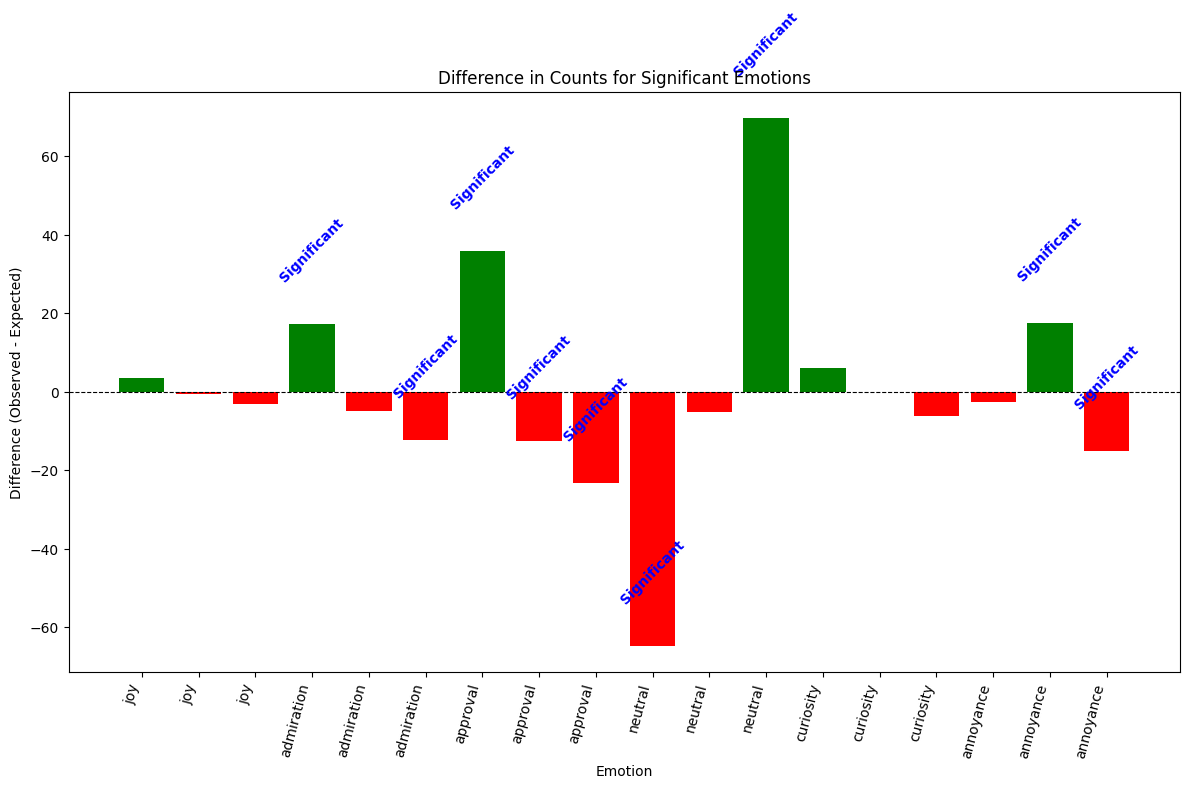

In [45]:
import matplotlib.pyplot as plt

# Calculate the difference between observed and expected counts
difference = np.array(sig_actual_counts) - np.array(sig_expected_counts)

# Flatten the difference array to a 1D array
difference_flat = difference.flatten()
print(difference_flat)

# Define sentiments and corresponding indices for bar plotting
sentiments = ['Positive', 'Negative', 'Neutral']
indices = np.arange(len(significance_results) * len(sentiments))  # Indices for x-axis positions

# Define colors based on the sign of the difference
bar_colors = np.where(difference_flat > 0, 'green', 'red')

# Plotting the bar graph
plt.figure(figsize=(12, 8))
bars = plt.bar(indices, difference_flat, color=bar_colors)

# Add labels, title, and legend
plt.xlabel('Emotion')
plt.ylabel('Difference (Observed - Expected)')
plt.title('Difference in Counts for Significant Emotions')
emotions_repeated = np.repeat(significance_results, 3)
# plt.xticks(indices, np.tile(significance_results, len(sentiments)), rotation=45, ha='right')  # Set x-axis labels
plt.xticks(indices, emotions_repeated, rotation=75, ha='right')  # Set x-axis labels
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add horizontal line at y=0

# Add annotations for significant differences
for i, bar, diff in zip(indices, bars, difference_flat):
    if np.abs(diff) > 0.05 * np.mean(sig_expected_counts):
        plt.text(i, bar.get_height() + 10, 'Significant', ha='center', va='bottom', color='blue', weight='bold', rotation=45,)

plt.tight_layout()
plt.show()


Zephyr

In [46]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import chisquare

# Initialize the text classification pipeline for emotion analysis (Go emotions from Hugging Face)
# (see link above)
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5)

cmv_df = pd.read_csv('ZE*.csv')

# Define the mapping of emotions to sentiment categories
# From Go Emotions dataset (see link above)
emotion_sentiment_mapping = {
    'joy': 'positive',
    'optimism': 'positive',
    'amusement': 'positive',
    'love': 'positive',
    'excitement': 'positive',
    'admiration': 'positive',
    'relief': 'positive',
    'gratitude': 'positive',
    'pride': 'positive',
    'caring': 'positive',
    'approval': 'positive',
    'neutral': 'neutral',
    'surprise': 'neutral',
    'realization': 'neutral',
    'confusion': 'neutral',
    'curiosity': 'neutral',
    'disapproval': 'negative',
    'desire': 'negative',
    'remorse': 'negative',
    'disappointment': 'negative',
    'annoyance': 'negative',
    'nervousness': 'negative',
    'anger': 'negative',
    'fear': 'negative',
    'embarassment': 'negative',
    'sadness': 'negative',
    'grief': 'negative',
    'disgust': 'negative',
}

# Initialize count var for batch logging progress
count = 0

# Create a dictionary to store sentiment frequencies
sentiment_frequency = {'positive': 0, 'negative': 0, 'neutral': 0}

# Create a dictionary to store emotion frequencies for each sentiment category
emotion_frequency = {'positive': {}, 'negative': {}, 'neutral': {}}

def is_statistically_significant(sentiment_counts, sentiment_frequency):
    # Calculate the sum of observed frequencies (ie how many times did the emotion show up across all types of posts)
    observed_sum = sentiment_counts.sum()

    # Calculate the total number of posts
    total_posts = sum(sentiment_frequency.values())

    # Calculate expected proportions based on post distribution
    if total_posts > 0:
        expected_proportions = np.array([sentiment_frequency[key] / total_posts for key in sentiment_frequency.keys()])
        expected_counts = expected_proportions * observed_sum

    # Perform chi-squared test
    chi2_stat, p_val = chisquare(sentiment_counts, f_exp=expected_counts)

    # Determine if the test is statistically significant based on the p-value
    if p_val < 0.05:  # You can adjust the significance level (alpha) as needed
        print(f"Expected counts would have been: {expected_counts}")
        sig_expected_counts.append(expected_counts)
        print(f"Actual counts were: {sentiment_counts}")
        sig_actual_counts.append(sentiment_counts)
        return True, chi2_stat, p_val
    else:
        return False, chi2_stat, p_val

# Iterate over each row in the DataFrame
for index, row in cmv_df.iterrows():
    # Log Progress every 200 batches
    # if (count / 5) > 199:
    #     break;
    if (count / 5) % 25 == 0:
      print(f"Number of Posts analyzed: {int(count / 5)}")
      print(" Post Sentiment Distribution")
      print(sentiment_frequency)
      print("")
    # if (count / 5) % 5 == 0:
    #   print(f"Number of Posts analyzed: {int(count / 5)}")
    #   print(" Post Sentiment Distribution")
    #   print(sentiment_frequency)
    #   print("")

    #   print(" Comment Emotion Distribution for Posts")
    #   print(emotion_frequency)
    #   print("")

    # Process the post body for sentiment analysis
    post_body = str(row['Query'])

    # Truncate post_body if it exceeds 512 characters
    post_body = post_body[:512]

    if post_body:
        # print(post_body)
        # print("")
        # Analyze emotions of the post body
        emotions = classifier(post_body)

        # Make sure we have emotions for the post
        if emotions and len(emotions) > 0 and count % 5 == 0:
            # print(post_body)
            # Grab the top emotion for the post body
            top_emotion_post = emotions[0][0]['label']
            # print("")
            # print(top_emotion_post)
            # print("")

            # print(top_emotion_post)
            # print("")
            # print("")
            if top_emotion_post in emotion_sentiment_mapping:
                # Convert that top emotion into a sentiment (positive/neutral/negative)
                # for later analysis
                post_sentiment = emotion_sentiment_mapping[top_emotion_post]

                # Update sentiment frequency of posts
                sentiment_frequency[post_sentiment] += 1
            # print(sentiment_frequency)

        response = row[f'Response']
        if isinstance(response, str):
            response = response[:512]
            # print(response)

            output = classifier(response)
            # print(output)
            # Grab emotion labels for each output
            top_emotion_comment = output[0][0]['label']
            # Update emotion frequency dictionary
            if top_emotion_comment not in emotion_frequency[post_sentiment]:
                # If the emotion does not exist, set freq to be 1 for the emotion
                emotion_frequency[post_sentiment][top_emotion_comment] = 1
            else:
                # Otherwise increment the current count for the emotion
                emotion_frequency[post_sentiment][top_emotion_comment] += 1

        # increment our overall count that does batch logging
        count += 1

# Define the sentiment categories in the desired order
sentiment_categories = ['positive', 'negative', 'neutral']

# Define the complete list of emotions from the mapping
all_emotions = list(emotion_sentiment_mapping.keys())

# Initialize the contingency table with zeros
contingency_table = np.zeros((len(sentiment_categories), len(all_emotions)), dtype=int)

# Populate the contingency table with emotion frequencies
for i, sentiment in enumerate(sentiment_categories):
    for j, emotion in enumerate(all_emotions):
        if emotion in emotion_frequency[sentiment]:
            contingency_table[i, j] = emotion_frequency[sentiment][emotion]

# Emotion of interest (column index)
emotion_index = 0
significance_results = []
sig_expected_counts = []
sig_actual_counts = []
p_value_results = []

# Extract all sentiment values for the specified emotion (column)
for emotion in emotion_sentiment_mapping:
  # print(emotion_index)
  # print(emotion)
  sentiment_counts = contingency_table[:, emotion_index]
  # print(sentiment_counts)

  if np.all(sentiment_counts >= 1):
      is_significant, chi2_stat, p_val = is_statistically_significant(sentiment_counts, sentiment_frequency)

      print(f"Is the difference statistically significant? for emotion : {emotion}")
      if is_significant:
        print("Yes, it was significant")
        significance_results.append(emotion)
        p_value_results.append(p_val)
      else:
        print("No, it was not significant")
  else:
      print(f"Not enough information to perform the chi-squared test for emotion: {emotion}")

  emotion_index += 1

print("Final Post Sentiment Distribution")
print(sentiment_frequency)
print("")

print("Final Comment Emotion Distribution for Posts")
print(emotion_frequency)
print("")

# Number of Posts analyzed: 600
#  Post Sentiment Distribution
# {'positive': 89, 'negative': 91, 'neutral': 420}

# Expected counts would have been: [ 4.2962963   4.38969404 20.31400966]
# Actual counts were: [10  7 12]
# Is the difference statistically significant? for emotion : joy
# Yes, it was significant
# Is the difference statistically significant? for emotion : optimism
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: amusement
# Not enough information to perform the chi-squared test for emotion: love
# Not enough information to perform the chi-squared test for emotion: excitement
# Expected counts would have been: [ 8.74074074  8.93075684 41.32850242]
# Actual counts were: [23  2 34]
# Is the difference statistically significant? for emotion : admiration
# Yes, it was significant
# Not enough information to perform the chi-squared test for emotion: relief
# Not enough information to perform the chi-squared test for emotion: gratitude
# Not enough information to perform the chi-squared test for emotion: pride
# Expected counts would have been: [ 8.74074074  8.93075684 41.32850242]
# Actual counts were: [17  8 34]
# Is the difference statistically significant? for emotion : caring
# Yes, it was significant
# Expected counts would have been: [105.48148148 107.77455717 498.74396135]
# Actual counts were: [145 125 442]
# Is the difference statistically significant? for emotion : approval
# Yes, it was significant
# Expected counts would have been: [ 303.40740741  310.00322061 1434.58937198]
# Actual counts were: [ 240  296 1512]
# Is the difference statistically significant? for emotion : neutral
# Yes, it was significant
# Not enough information to perform the chi-squared test for emotion: surprise
# Is the difference statistically significant? for emotion : realization
# No, it was not significant
# Is the difference statistically significant? for emotion : confusion
# No, it was not significant
# Expected counts would have been: [ 2.37037037  2.42190016 11.20772947]
# Actual counts were: [6 4 6]
# Is the difference statistically significant? for emotion : curiosity
# Yes, it was significant
# Expected counts would have been: [ 7.40740741  7.568438   35.02415459]
# Actual counts were: [ 7 14 29]
# Is the difference statistically significant? for emotion : disapproval
# Yes, it was significant
# Is the difference statistically significant? for emotion : desire
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: remorse
# Is the difference statistically significant? for emotion : disappointment
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: annoyance
# Not enough information to perform the chi-squared test for emotion: nervousness
# Not enough information to perform the chi-squared test for emotion: anger
# Not enough information to perform the chi-squared test for emotion: fear
# Not enough information to perform the chi-squared test for emotion: embarassment
# Is the difference statistically significant? for emotion : sadness
# No, it was not significant
# Not enough information to perform the chi-squared test for emotion: grief
# Not enough information to perform the chi-squared test for emotion: disgust
# Final Post Sentiment Distribution
# {'positive': 92, 'negative': 94, 'neutral': 435}

# Final Comment Emotion Distribution for Posts
# {'positive': {'approval': 145, 'neutral': 240, 'caring': 17, 'disappointment': 1, 'admiration': 23, 'curiosity': 6, 'confusion': 3, 'desire': 1, 'disapproval': 7, 'realization': 1, 'optimism': 2, 'gratitude': 1, 'joy': 10, 'sadness': 1, 'annoyance': 2}, 'negative': {'neutral': 296, 'approval': 125, 'caring': 8, 'disappointment': 2, 'joy': 7, 'disapproval': 14, 'admiration': 2, 'curiosity': 4, 'sadness': 2, 'confusion': 4, 'optimism': 1, 'desire': 2, 'nervousness': 2, 'realization': 1}, 'neutral': {'neutral': 1512, 'disapproval': 29, 'optimism': 12, 'approval': 442, 'admiration': 34, 'caring': 34, 'nervousness': 3, 'realization': 9, 'confusion': 27, 'fear': 3, 'joy': 12, 'love': 2, 'sadness': 11, 'annoyance': 7, 'disappointment': 12, 'curiosity': 6, 'anger': 2, 'excitement': 2, 'gratitude': 2, 'remorse': 5, 'desire': 5, 'amusement': 1}}

Number of Posts analyzed: 0
 Post Sentiment Distribution
{'positive': 0, 'negative': 0, 'neutral': 0}

Number of Posts analyzed: 25
 Post Sentiment Distribution
{'positive': 2, 'negative': 6, 'neutral': 17}

Number of Posts analyzed: 50
 Post Sentiment Distribution
{'positive': 7, 'negative': 7, 'neutral': 36}

Number of Posts analyzed: 75
 Post Sentiment Distribution
{'positive': 14, 'negative': 12, 'neutral': 49}

Number of Posts analyzed: 100
 Post Sentiment Distribution
{'positive': 18, 'negative': 12, 'neutral': 70}

Number of Posts analyzed: 125
 Post Sentiment Distribution
{'positive': 22, 'negative': 13, 'neutral': 90}

Number of Posts analyzed: 150
 Post Sentiment Distribution
{'positive': 28, 'negative': 16, 'neutral': 106}

Number of Posts analyzed: 175
 Post Sentiment Distribution
{'positive': 30, 'negative': 20, 'neutral': 125}

Number of Posts analyzed: 200
 Post Sentiment Distribution
{'positive': 35, 'negative': 24, 'neutral': 141}

Number of Posts analyzed: 225
 Post S

[  5.7037037    2.61030596  -8.31400966  14.25925926  -6.93075684
  -7.32850242   8.25925926  -0.93075684  -7.32850242  39.51851852
  17.22544283 -56.74396135 -63.40740741 -14.00322061  77.41062802
   3.62962963   1.57809984  -5.20772947  -0.40740741   6.431562
  -6.02415459]


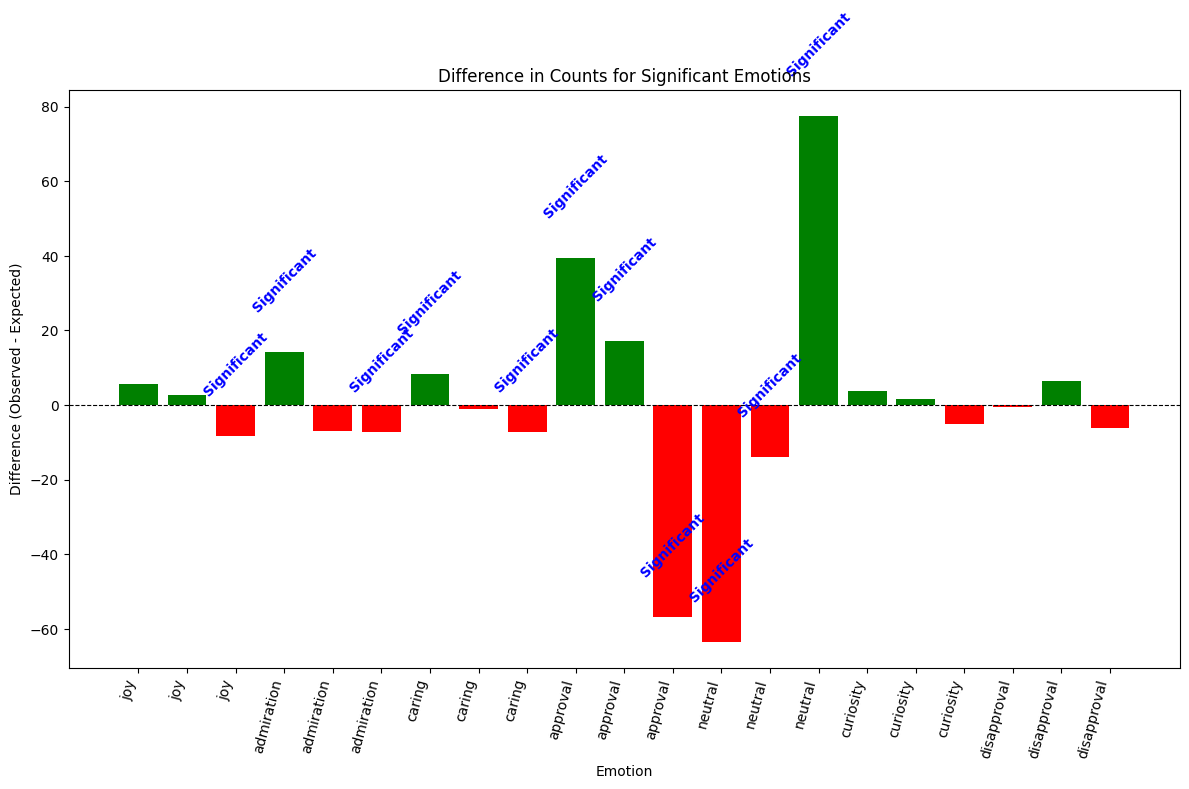

In [47]:
import matplotlib.pyplot as plt

# Calculate the difference between observed and expected counts
difference = np.array(sig_actual_counts) - np.array(sig_expected_counts)

# Flatten the difference array to a 1D array
difference_flat = difference.flatten()
print(difference_flat)

# Define sentiments and corresponding indices for bar plotting
sentiments = ['Positive', 'Negative', 'Neutral']
indices = np.arange(len(significance_results) * len(sentiments))  # Indices for x-axis positions

# Define colors based on the sign of the difference
bar_colors = np.where(difference_flat > 0, 'green', 'red')

# Plotting the bar graph
plt.figure(figsize=(12, 8))
bars = plt.bar(indices, difference_flat, color=bar_colors)

# Add labels, title, and legend
plt.xlabel('Emotion')
plt.ylabel('Difference (Observed - Expected)')
plt.title('Difference in Counts for Significant Emotions')
emotions_repeated = np.repeat(significance_results, 3)
# plt.xticks(indices, np.tile(significance_results, len(sentiments)), rotation=45, ha='right')  # Set x-axis labels
plt.xticks(indices, emotions_repeated, rotation=75, ha='right')  # Set x-axis labels
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add horizontal line at y=0

# Add annotations for significant differences
for i, bar, diff in zip(indices, bars, difference_flat):
    if np.abs(diff) > 0.05 * np.mean(sig_expected_counts):
        plt.text(i, bar.get_height() + 10, 'Significant', ha='center', va='bottom', color='blue', weight='bold', rotation=45,)

plt.tight_layout()
plt.show()